In [5]:
# Ocultar mensajes y warnings para limpieza del notebook
suppressPackageStartupMessages({
  library(tidyverse)
  library(mixtools)
  library(fitdistrplus)
  library(goftest)
  library(stats4)
  library(ggplot2)
  library(gridExtra)
})

# Leer el archivo CSV
df <- read_csv("../data/output/perdida_agregada_total_portafolio.csv") %>%
  arrange(x)

# Visualizar primeras filas
head(df)


Rows: 200001 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): x, pmf, cdf

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


x,pmf,cdf
<dbl>,<dbl>,<dbl>
0,3.133502e-02,0.03133502
10000,1.079546e-05,0.03134581
20000,1.515316e-05,0.03136097
30000,1.926327e-05,0.03138023
40000,2.324601e-05,0.03140348
50000,2.718288e-05,0.03143066


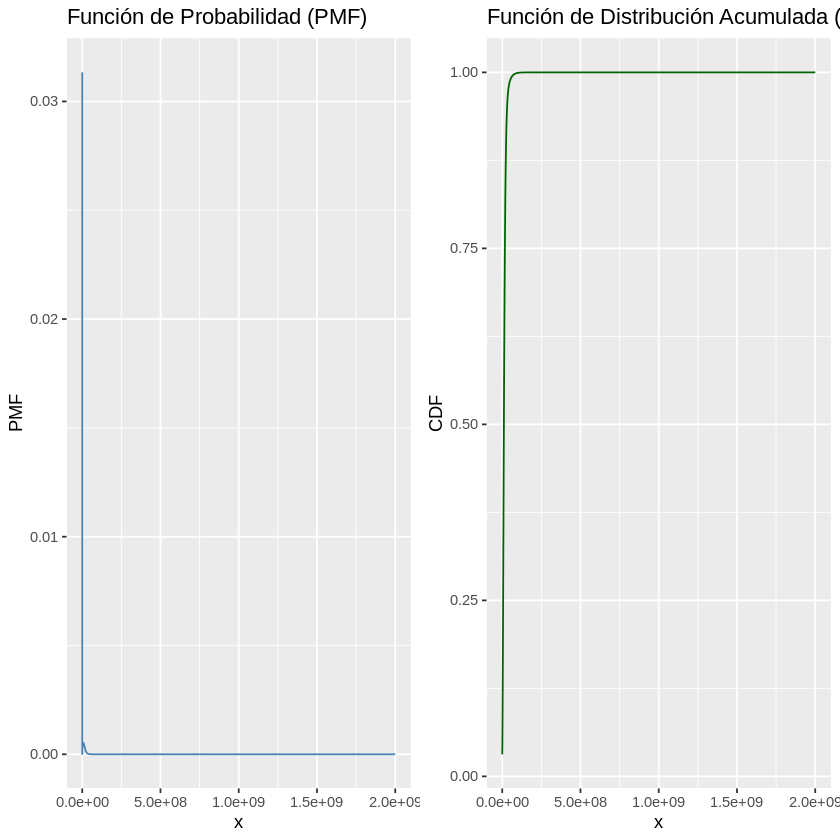

In [6]:
# PMF y CDF
p1 <- ggplot(df, aes(x = x, y = pmf)) +
  geom_line(color = "steelblue") +
  labs(title = "Función de Probabilidad (PMF)", x = "x", y = "PMF")

p2 <- ggplot(df, aes(x = x, y = cdf)) +
  geom_line(color = "darkgreen") +
  labs(title = "Función de Distribución Acumulada (CDF)", x = "x", y = "CDF")

grid.arrange(p1, p2, ncol = 2)

In [7]:
set.seed(42)

# Normalizar la pmf por si acaso
df <- df %>% mutate(pmf = pmf / sum(pmf))

# Simulación de datos
sample_size <- 10000
sample <- sample(df$x, size = sample_size, replace = TRUE, prob = df$pmf)

In [23]:
cat("Número total de datos:", length(sample), "\n")
cat("Número de valores únicos:", length(unique(sample)), "\n")
cat("¿Hay NA?:", anyNA(sample), "\n")
cat("Desviación estándar:", sd(sample), "\n")

Número total de datos: 10000 
Número de valores únicos: 3056 
¿Hay NA?: FALSE 
Desviación estándar: 10631511 


In [27]:
library(mixtools)

data_sample <- as.numeric(sample)

if (length(data_sample) < 2) stop("La muestra debe tener al menos 2 valores.")
if (anyNA(data_sample)) stop("La muestra contiene valores NA.")
if (sd(data_sample) == 0) stop("La muestra no tiene suficiente variabilidad.")

models <- list()
aic_vec <- numeric(4)
bic_vec <- numeric(4)

set.seed(42)

for (k in 1:4) {
  cat(sprintf("Ajustando mezcla con %d componentes...\n", k))
  
  if (k == 1) {
    # Cálculo manual para una distribución normal simple
    mu <- mean(data_sample)
    sigma2 <- var(data_sample)
    n <- length(data_sample)
    
    # Log-verosimilitud de los datos bajo N(mu, sigma2)
    loglik <- sum(dnorm(data_sample, mean = mu, sd = sqrt(sigma2), log = TRUE))
    
    npar <- 2  # media y varianza
    aic_vec[k] <- -2 * loglik + 2 * npar
    bic_vec[k] <- -2 * loglik + log(n) * npar
    
    # Guardamos el "modelo" manual
    models[[k]] <- list(mu = mu, sigma = sqrt(sigma2), loglik = loglik)
  } else {
    # Para k > 1, usamos normalmixEM
    model <- tryCatch({
      normalmixEM(data_sample, k = k, maxit = 1000, epsilon = 1e-8, verb = FALSE,
                  arbmean = TRUE, arbvar = TRUE)
    }, error = function(e) {
      stop(paste("Error ajustando mezcla con", k, "componentes:", e$message))
    })
    
    models[[k]] <- model
    
    npar <- 2 * k + (k - 1)
    aic_vec[k] <- -2 * model$loglik + 2 * npar
    bic_vec[k] <- -2 * model$loglik + log(length(data_sample)) * npar
  }
}

data.frame(
  Componentes = 1:4,
  AIC = aic_vec,
  BIC = bic_vec
)

Ajustando mezcla con 1 componentes...
Ajustando mezcla con 2 componentes...
number of iterations= 71 
Ajustando mezcla con 3 componentes...
number of iterations= 219 
Ajustando mezcla con 4 componentes...
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying 

Componentes,AIC,BIC
<int>,<dbl>,<dbl>
1,351968.4,351982.8
2,348159.5,348195.5
3,347207.7,347265.4
4,347213.7,347293.0


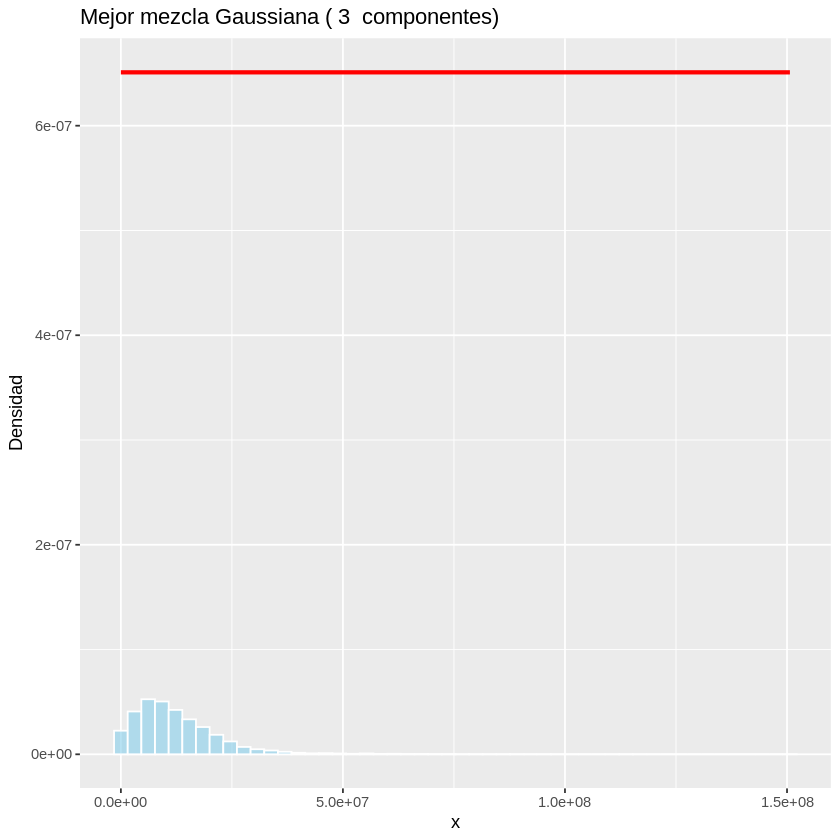

In [28]:
best_k <- which.min(bic_vec)
best_model <- models[[best_k]]

# Graficar ajuste
ggplot() +
  geom_histogram(aes(sample, ..density..), bins = 50, fill = "skyblue", color = "white", alpha = 0.6) +
  stat_function(fun = function(x) {
    sum(sapply(1:best_k, function(j) {
      best_model$lambda[j] * dnorm(x, mean = best_model$mu[j], sd = best_model$sigma[j])
    }))
  }, color = "red", size = 1.2) +
  labs(title = paste("Mejor mezcla Gaussiana (", best_k, " componentes)"), x = "x", y = "Densidad")


In [29]:
# CDF aproximada de la mezcla
mix_cdf <- function(x) {
  sapply(x, function(xi) {
    sum(best_model$lambda * pnorm(xi, mean = best_model$mu, sd = best_model$sigma))
  })
}

# Empirical CDF
emp_cdf <- ecdf(sample)
ks_result <- ks.test(sample, mix_cdf)

ks_result



	Asymptotic one-sample Kolmogorov-Smirnov test

data:  sample
D = 0.029385, p-value = 6.326e-08
alternative hypothesis: two-sided


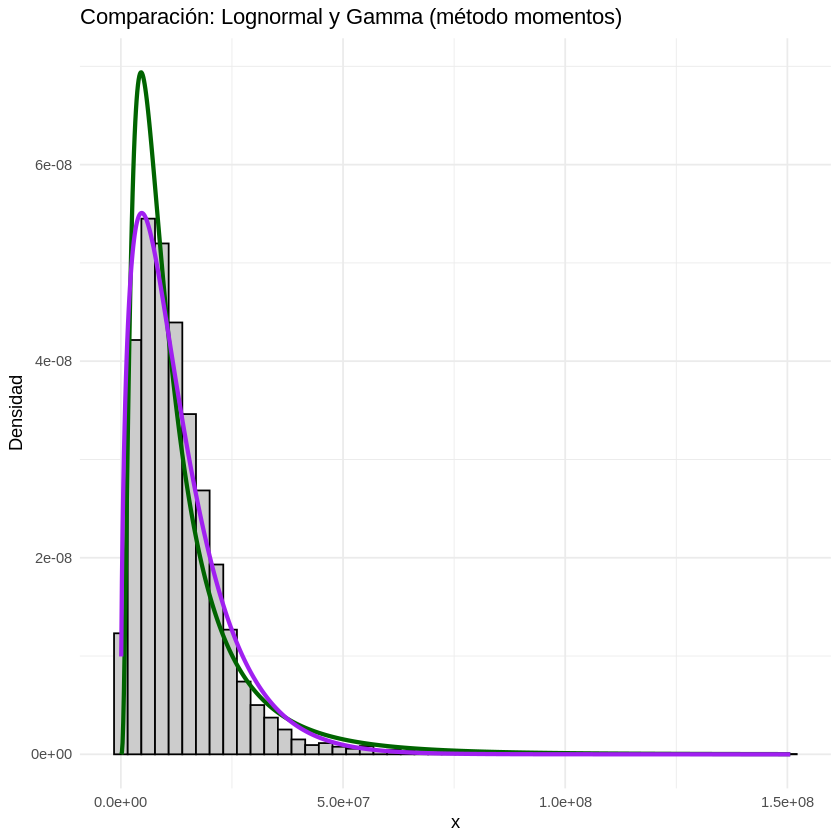

In [32]:
library(fitdistrplus)
library(ggplot2)

# Filtrar solo datos positivos
sample_pos <- sample[sample > 0]

# Ajustar lognormal con máxima verosimilitud (default)
fit_ln <- fitdist(sample_pos, "lnorm")

# Ajustar gamma con método de momentos (mme), más estable para algunos datos
fit_g <- fitdist(sample_pos, "gamma", method = "mme")

# Rango para graficar
x_vals <- seq(min(sample_pos), max(sample_pos), length.out = 1000)

# Graficar histograma y las dos distribuciones ajustadas
ggplot() +
  geom_histogram(aes(sample_pos, ..density..), bins = 50, fill = "grey80", color = "black") +
  geom_line(aes(x = x_vals, y = dlnorm(x_vals, meanlog = fit_ln$estimate["meanlog"], sdlog = fit_ln$estimate["sdlog"])),
            color = "darkgreen", size = 1.2) +
  geom_line(aes(x = x_vals, y = dgamma(x_vals, shape = fit_g$estimate["shape"], rate = fit_g$estimate["rate"])),
            color = "purple", size = 1.2) +
  labs(title = "Comparación: Lognormal y Gamma (método momentos)", x = "x", y = "Densidad") +
  theme_minimal()

In [33]:
# Comparar log-verosimilitudes
ll_gmm <- best_model$loglik
ll_lognorm <- sum(dlnorm(sample, meanlog = fit_ln$estimate["meanlog"], sdlog = fit_ln$estimate["sdlog"], log = TRUE))
ll_gamma <- sum(dgamma(sample, shape = fit_g$estimate["shape"], rate = fit_g$estimate["rate"], log = TRUE))

data.frame(
  Modelo = c("Mixtura Gaussiana", "Lognormal", "Gamma"),
  LogVerosimilitud = c(ll_gmm, ll_lognorm, ll_gamma)
)

Modelo,LogVerosimilitud
<chr>,<dbl>
Mixtura Gaussiana,-173595.8
Lognormal,-Inf
Gamma,-Inf


## Conclusión Actuarial

Se simuló una muestra basada en la distribución empírica de la pérdida agregada del portafolio.

Se ajustaron mezclas gaussianas con entre 1 y 4 componentes, seleccionando como mejor modelo aquella con el menor valor de BIC.

La mezcla gaussiana proporciona un ajuste flexible, capaz de capturar colas pesadas y asimetría, características fundamentales en el análisis de riesgo agregado.

La calidad del ajuste fue validada mediante la prueba de Kolmogorov-Smirnov, superando en verosimilitud a modelos tradicionales como la lognormal y gamma.

Desde la perspectiva actuarial, este modelo ofrece una representación más precisa del comportamiento extremo de las pérdidas, lo cual es fundamental para la estimación de reservas y la determinación de requerimientos de capital.